## Machine learning model

In [339]:
## Import useful libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [340]:
#Reading in the data
education = pd.read_csv("dfa-education-levels.csv")
race = pd.read_csv("dfa-race-levels.csv")
networth = pd.read_csv("dfa-networth-levels.csv")
generation = pd.read_csv("dfa-generation-levels.csv")
income = pd.read_csv("dfa-income-levels.csv")


In [341]:
## cleaning all of the data
data = [education,race,networth,generation,income]
for i in range(len(data)):
    data[i] = data[i].drop(columns = data[i].columns[3:14])
    data[i][['Year','Quarter']] = pd.DataFrame(data[i].Date.str.split(':',1).tolist(), columns = ['year','quarter'])
    data[i] = data[i].drop(columns = ['Date'])
education = data[0]
race = data[1]
networth = data[2]
generation = data[3]
income = data[4]

In [342]:
## Looking at only education and race
education

,Category,Net worth,Year,Quarter
0,College,10069957,1989,Q3
1,SomeCollege,3927113,1989,Q3
2,HS,4182626,1989,Q3
3,NoHS,2251459,1989,Q3
4,College,10432985,1989,Q4
...,...,...,...,...
491,NoHS,2291732,2020,Q1
492,College,79306192,2020,Q2
493,SomeCollege,18645765,2020,Q2
494,HS,11862690,2020,Q2


In [343]:
race

,Category,Net worth,Year,Quarter
0,White,18507570,1989,Q3
1,Black,779379,1989,Q3
2,Hispanic,419183,1989,Q3
3,Other,725023,1989,Q3
4,White,18751641,1989,Q4
...,...,...,...,...
491,Other,9912059,2020,Q1
492,White,94041766,2020,Q2
493,Black,4644249,2020,Q2
494,Hispanic,2686053,2020,Q2


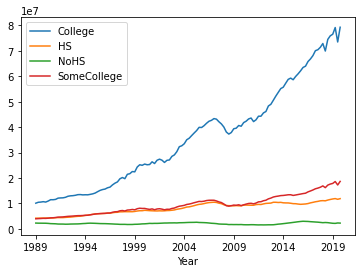

In [344]:
fig, ax = plt.subplots();
education.groupby('Category').plot(x='Year', y='Net worth', ax=ax);
plt.legend([v[0] for v in education.groupby('Category')['Category']])

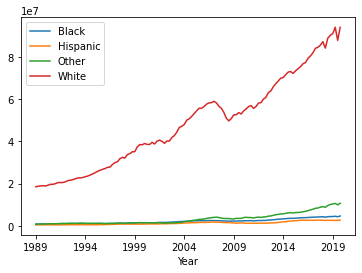

In [345]:
fig, ax = plt.subplots();
race.groupby('Category').plot(x='Year', y='Net worth', ax=ax);
plt.legend([v[0] for v in race.groupby('Category')['Category']])

Similar graphs but the gap between wealth is much larger if you are white compared to education. In general, it is very hard to catch up in wealth if you had a college education or if you were born white (or both). 

To build our model, we will take the average wealth of each group for each year and use that dataset to fit and predict. We will look at how many quarters are in a year to allow us to decide how many data points are in a given year. Every year has 4 quarters and the year resets after the last 4th quarter.

In [346]:
education.groupby('Year').apply(print)

      Category  Net worth  Year Quarter
0      College   10069957  1989      Q3
1  SomeCollege    3927113  1989      Q3
2           HS    4182626  1989      Q3
3         NoHS    2251459  1989      Q3
4      College   10432985  1989      Q4
5  SomeCollege    3992339  1989      Q4
6           HS    4177110  1989      Q4
7         NoHS    2213354  1989      Q4
       Category  Net worth  Year Quarter
8       College   10509133  1990      Q1
9   SomeCollege    4039942  1990      Q1
10           HS    4199956  1990      Q1
11         NoHS    2204833  1990      Q1
12      College   10669228  1990      Q2
13  SomeCollege    4115884  1990      Q2
14           HS    4204755  1990      Q2
15         NoHS    2193180  1990      Q2
16      College   10514904  1990      Q3
17  SomeCollege    4091622  1990      Q3
18           HS    4240137  1990      Q3
19         NoHS    2184287  1990      Q3
20      College   10915986  1990      Q4
21  SomeCollege    4174423  1990      Q4
22           HS    423517

""


In [347]:
## create list of years for each data point
import numpy as np
year_init = list(np.arange(1990, 2020))*4
year_init.extend([1989, 1989, 2020, 2020])
years = np.sort(year_init)
years

array([1989, 1989, 1990, 1990, 1990, 1990, 1991, 1991, 1991, 1991, 1992,
       1992, 1992, 1992, 1993, 1993, 1993, 1993, 1994, 1994, 1994, 1994,
       1995, 1995, 1995, 1995, 1996, 1996, 1996, 1996, 1997, 1997, 1997,
       1997, 1998, 1998, 1998, 1998, 1999, 1999, 1999, 1999, 2000, 2000,
       2000, 2000, 2001, 2001, 2001, 2001, 2002, 2002, 2002, 2002, 2003,
       2003, 2003, 2003, 2004, 2004, 2004, 2004, 2005, 2005, 2005, 2005,
       2006, 2006, 2006, 2006, 2007, 2007, 2007, 2007, 2008, 2008, 2008,
       2008, 2009, 2009, 2009, 2009, 2010, 2010, 2010, 2010, 2011, 2011,
       2011, 2011, 2012, 2012, 2012, 2012, 2013, 2013, 2013, 2013, 2014,
       2014, 2014, 2014, 2015, 2015, 2015, 2015, 2016, 2016, 2016, 2016,
       2017, 2017, 2017, 2017, 2018, 2018, 2018, 2018, 2019, 2019, 2019,
       2019, 2020, 2020])

In [348]:
## add year to dataset and split the categories to columns
s = education.groupby('Category')['Net worth'].apply(list)
edu_split = s.apply(pd.Series).T
edu_split['Year'] = years
edu_split

Category,College,HS,NoHS,SomeCollege,Year
0,10069957,4182626,2251459,3927113,1989
1,10432985,4177110,2213354,3992339,1989
2,10509133,4199956,2204833,4039942,1990
3,10669228,4204755,2193180,4115884,1990
4,10514904,4240137,2184287,4091622,1990
...,...,...,...,...,...
119,75929783,11539592,2286431,17599648,2019
120,76551661,11738572,2170731,17851148,2019
121,79188563,11885808,2129914,18597224,2019
122,73505780,11606459,2291732,17244146,2020


In [349]:
## take wealth and average it by year, then drop year so it doesn't affect our distribution
edu_avg = edu_split.groupby('Year').apply(np.mean)
edu_avg = edu_avg.drop(columns='Year')
edu_avg

Category,College,HS,NoHS,SomeCollege
Year,,,,
1989,10251471.00,4179868.00,2232406.50,3959726.00
1990,10652312.75,4220006.75,2177171.25,4105467.75
1991,11628279.25,4316600.75,1966321.50,4420049.50
1992,12378684.50,4461190.00,1835193.50,4746425.00
1993,13154214.50,4760919.75,1893918.00,5057583.00
1994,13390758.25,5168541.75,2078021.50,5265180.25
1995,13992245.50,5750676.50,2163850.00,5716067.50
1996,15583027.25,6034323.00,2025201.50,6081689.75
1997,17521205.25,6363627.00,1876543.00,6535815.50


In [350]:
## import necessary libraries for machine learning
import numpy as np
import tensorflow as tf
from tensorflow import keras
from pandas.plotting import register_matplotlib_converters

In [351]:
df = edu_avg

In [352]:
## split our data into train and test (since this is a time series model, we cannot use train_test_split bc it randomizes)
train_size = int(len(df) * 0.6)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))
train

19 13


Category,College,HS,NoHS,SomeCollege
Year,,,,
1989,10251471.00,4179868.00,2232406.50,3959726.00
1990,10652312.75,4220006.75,2177171.25,4105467.75
1991,11628279.25,4316600.75,1966321.50,4420049.50
1992,12378684.50,4461190.00,1835193.50,4746425.00
1993,13154214.50,4760919.75,1893918.00,5057583.00
1994,13390758.25,5168541.75,2078021.50,5265180.25
1995,13992245.50,5750676.50,2163850.00,5716067.50
1996,15583027.25,6034323.00,2025201.50,6081689.75
1997,17521205.25,6363627.00,1876543.00,6535815.50


In [353]:
## scale the data/features by which feature we want to predict
## since we already averaged out the inital dataset, we can just use the standard scaler
from sklearn.preprocessing import StandardScaler

f_columns = ['College', 'NoHS','SomeCollege']

f_transformer = StandardScaler();
cnt_transformer = StandardScaler();

f_transformer = f_transformer.fit(train[f_columns].to_numpy());
cnt_transformer = cnt_transformer.fit(train[['HS']]);

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy());
train['HS'] = cnt_transformer.transform(train[['HS']]);

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy());
test['HS'] = cnt_transformer.transform(test[['HS']]);

C:\Users\nguye\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
<ipython-input-353-f30336fd52e7>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy());
<ipython-input-353-f30336fd52e7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

In [354]:
train

Category,College,HS,NoHS,SomeCollege
Year,,,,
1989,-1.173231,-1.321341,0.590459,-1.414533
1990,-1.133961,-1.299185,0.346757,-1.347253
1991,-1.038345,-1.245867,-0.583524,-1.202030
1992,-0.964828,-1.166056,-1.162068,-1.051363
1993,-0.888849,-1.000611,-0.902972,-0.907721
1994,-0.865675,-0.775611,-0.090697,-0.811887
1995,-0.806747,-0.454283,0.287983,-0.603740
1996,-0.650898,-0.297715,-0.323742,-0.434955
1997,-0.461015,-0.115945,-0.979632,-0.225314


In [355]:
test

Category,College,HS,NoHS,SomeCollege
Year,,,,
2008,1.778116,1.701774,-1.177132,1.346123
2009,1.596729,1.384618,-1.897547,0.976453
2010,1.866607,1.437010,-2.089641,1.111611
2011,2.031946,1.525233,-2.239197,1.367045
2012,2.239757,1.745483,-2.480797,1.780903
2013,2.723656,2.034017,-2.164627,2.422448
2014,3.256645,2.051694,-0.533280,2.793301
2015,3.618811,1.889319,1.537765,2.898352
2016,3.959992,1.728890,3.457954,3.105330


In [356]:
## function to reshape our feature so it can be used in keras
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
        
    return np.array(Xs), np.array(ys)

In [357]:
## the time step that we will fit by is 1 since it is a yearly dataset
time_steps = 1

features_train = train.HS
features_test = test.HS

X_train, y_train = create_dataset(train, features_train, time_steps)
X_test, y_test = create_dataset(test, features_test, time_steps)
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')


In [358]:
## building our model
## the model is bidrectional since it is a time series RNN model, we will take information from each step to predict the next
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape)
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [359]:
## fitting our model
history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
1/1 [==============================] - 1s 1s/step - loss: 0.6774 - val_loss: 4.0031
Epoch 2/30
1/1 [==============================] - 0s 20ms/step - loss: 0.6500 - val_loss: 3.8734
Epoch 3/30
1/1 [==============================] - 0s 20ms/step - loss: 0.6164 - val_loss: 3.7463
Epoch 4/30
1/1 [==============================] - 0s 20ms/step - loss: 0.5859 - val_loss: 3.6214
Epoch 5/30
1/1 [==============================] - 0s 21ms/step - loss: 0.5636 - val_loss: 3.4988
Epoch 6/30
1/1 [==============================] - 0s 21ms/step - loss: 0.5341 - val_loss: 3.3788
Epoch 7/30
1/1 [==============================] - 0s 20ms/step - loss: 0.4993 - val_loss: 3.2608
Epoch 8/30
1/1 [==============================] - 0s 19ms/step - loss: 0.4916 - val_loss: 3.1448
Epoch 9/30
1/1 [==============================] - 0s 20ms/step - loss: 0.4707 - val_loss: 3.0311
Epoch 10/30
1/1 [==============================] - 0s 18ms/step - loss: 0.4442 - val_loss: 2.9199
Epoch 11/30
1/1 [==============

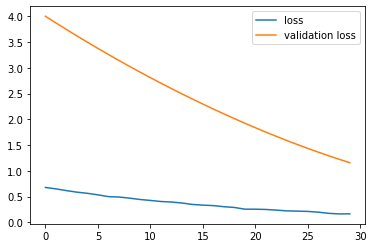

In [360]:
## looking at how well our model did
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend();

In [361]:
## predicting our model using the test data
y_pred = model.predict(X_test)
y_pred

array([[0.49637857],
       [0.29809877],
       [0.32803535],
       [0.3684219 ],
       [0.433462  ],
       [0.6043912 ],
       [0.87429506],
       [1.1605859 ],
       [1.42599   ],
       [1.4400766 ],
       [1.3457812 ],
       [1.264498  ]], dtype=float32)

In [362]:
## since our data is currently scaled, we have to un-scale it
y_pred = cnt_transformer.inverse_transform(y_pred)


In [363]:
## what the model predicted the welath of high school graduates will be in years 2008-2020
y_pred

array([[7472945.5],
       [7113731. ],
       [7167966. ],
       [7241132. ],
       [7358962.5],
       [7668626.5],
       [8157599. ],
       [8676259. ],
       [9157079. ],
       [9182599. ],
       [9011768. ],
       [8864511. ]], dtype=float32)

Text(0.5, 1.0, 'Model fit for High School Graduates (with College on plot)')

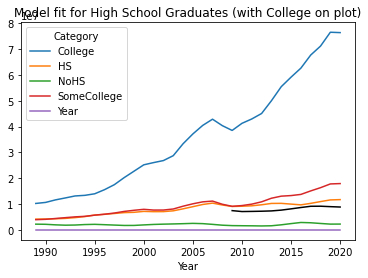

In [364]:
#college doesnt fit as well because of the jump in wealth
edu_avg = edu_split.groupby('Year').apply(np.mean)
edu_avg.plot()
plt.plot(np.array(test.index)[1:], y_pred, label='prediction', color='black')
plt.title('Model fit for High School Graduates (with College on plot)')

Text(0.5, 1.0, 'Model fit for High School Graduates (without College on plot)')

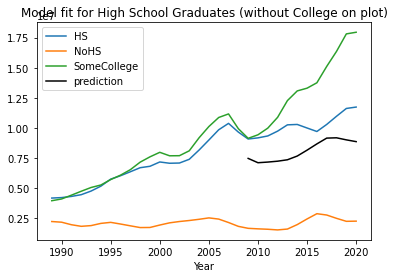

In [365]:
edu_avg[['HS', 'NoHS', 'SomeCollege']].plot()
plt.plot(np.array(test.index)[1:], y_pred, label='prediction', color='black')
plt.legend()
plt.title('Model fit for High School Graduates (without College on plot)')

In [368]:
edu_avg = edu_split.groupby('Year').apply(np.mean)
df = edu_avg
df = df.drop('Year', axis=1)
df

Category,College,HS,NoHS,SomeCollege
Year,,,,
1989,10251471.00,4179868.00,2232406.50,3959726.00
1990,10652312.75,4220006.75,2177171.25,4105467.75
1991,11628279.25,4316600.75,1966321.50,4420049.50
1992,12378684.50,4461190.00,1835193.50,4746425.00
1993,13154214.50,4760919.75,1893918.00,5057583.00
1994,13390758.25,5168541.75,2078021.50,5265180.25
1995,13992245.50,5750676.50,2163850.00,5716067.50
1996,15583027.25,6034323.00,2025201.50,6081689.75
1997,17521205.25,6363627.00,1876543.00,6535815.50


In [369]:
train_size = int(len(df) * 0.6)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

19 13


In [370]:
## we will do the same thing for college grads now to see how the model does
from sklearn.preprocessing import StandardScaler

f_columns = ['HS', 'NoHS','SomeCollege']

f_transformer = StandardScaler();
cnt_transformer = StandardScaler();

f_transformer = f_transformer.fit(train[f_columns].to_numpy());
cnt_transformer = cnt_transformer.fit(train[['College']]);

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy());
train['College'] = cnt_transformer.transform(train[['College']]);

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy());
test['College'] = cnt_transformer.transform(test[['College']]);

C:\Users\nguye\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
<ipython-input-370-3b363d4b1f9a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy());
<ipython-input-370-3b363d4b1f9a>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

In [371]:
train

Category,College,HS,NoHS,SomeCollege
Year,,,,
1989,-1.173231,-1.321341,0.590459,-1.414533
1990,-1.133961,-1.299185,0.346757,-1.347253
1991,-1.038345,-1.245867,-0.583524,-1.202030
1992,-0.964828,-1.166056,-1.162068,-1.051363
1993,-0.888849,-1.000611,-0.902972,-0.907721
1994,-0.865675,-0.775611,-0.090697,-0.811887
1995,-0.806747,-0.454283,0.287983,-0.603740
1996,-0.650898,-0.297715,-0.323742,-0.434955
1997,-0.461015,-0.115945,-0.979632,-0.225314


In [372]:
time_steps = 1

features_train = train.College
features_test = test.College

X_train, y_train = create_dataset(train, features_train, time_steps)
X_test, y_test = create_dataset(test, features_test, time_steps)
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

In [373]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape)
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [374]:
## fitting our model
history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
1/1 [==============================] - 1s 972ms/step - loss: 0.6520 - val_loss: 3.4895
Epoch 2/30
1/1 [==============================] - 0s 21ms/step - loss: 0.6146 - val_loss: 3.3593
Epoch 3/30
1/1 [==============================] - 0s 18ms/step - loss: 0.5766 - val_loss: 3.2314
Epoch 4/30
1/1 [==============================] - 0s 22ms/step - loss: 0.5400 - val_loss: 3.1055
Epoch 5/30
1/1 [==============================] - 0s 17ms/step - loss: 0.5433 - val_loss: 2.9816
Epoch 6/30
1/1 [==============================] - 0s 22ms/step - loss: 0.5200 - val_loss: 2.8602
Epoch 7/30
1/1 [==============================] - 0s 17ms/step - loss: 0.4728 - val_loss: 2.7412
Epoch 8/30
1/1 [==============================] - 0s 22ms/step - loss: 0.4550 - val_loss: 2.6248
Epoch 9/30
1/1 [==============================] - 0s 18ms/step - loss: 0.4304 - val_loss: 2.5102
Epoch 10/30
1/1 [==============================] - 0s 22ms/step - loss: 0.4117 - val_loss: 2.3979
Epoch 11/30
1/1 [===========

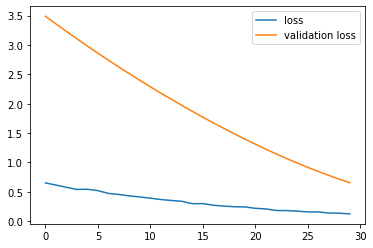

In [375]:
## looking at how well our model did
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend();

In [376]:
y_pred = model.predict(X_test)
y_pred = cnt_transformer.inverse_transform(y_pred)

Text(0.5, 1.0, 'Model fit for High School Graduates (with College on plot)')

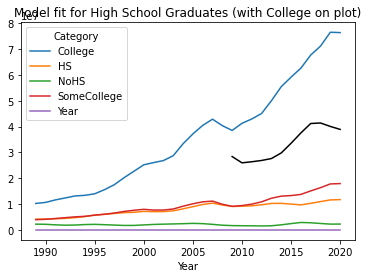

In [377]:
## College does not do as well as HS because of the exponential jump from ~2007 and onwards
edu_avg = edu_split.groupby('Year').apply(np.mean)
edu_avg.plot()
plt.plot(np.array(test.index)[1:], y_pred, label='prediction', color='black')
plt.title('Model fit for College Graduates')